# [ Chapter 9 - Personalized Search ]
# Personalized Search

**NOTE**: This notebook depends upon the the Retrotech dataset. If you have any issues, please rerun the [Setting up the Retrotech Dataset](../ch04/1.setting-up-the-retrotech-dataset.ipynb) notebook or execute the next cell uncommented.

In [1]:
import sys
sys.path.append('..')

In [2]:
import os
import sys

sys.path.append('..')
import pickle
import time
from collections import defaultdict
from datetime import datetime
from operator import itemgetter

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sklearn.cluster as cluster
from aips import *
from dataframe_functions import *
from IPython.display import HTML, display
from pyspark.conf import SparkConf
from pyspark.ml.feature import IndexToString, StringIndexer
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, explode

engine = get_engine()

In [3]:
#Recommended for making ALS run faster, if you have enough memory / cores allocated to docker
conf = SparkConf()
conf.set("spark.driver.memory", "8g")
conf.set("spark.executor.memory", "8g")
conf.set("spark.dynamicAllocation.enabled", "true")
conf.set("spark.dynamicAllocation.executorMemoryOverhead", "8g")
spark = SparkSession.builder.appName("AIPS-ch9").config(conf=conf).getOrCreate()

In [4]:
#%run ../ch04/1.setting-up-the-retrotech-dataset.ipynb

In [5]:
### Load product data
products_collection = engine.get_collection("products")
create_view_from_collection(products_collection, "products", spark)

# Collaborative Filtering with Implicit Preferences

In [6]:
def aggregate_signals(signals_collection, signals_agg_collection_name, query):
    aggregated_collection = engine.create_collection(signals_agg_collection_name)
    print("Aggregating Signals to Create Signals Boosts...")
    create_view_from_collection(signals_collection, "signals", spark)
    aggregated_collection.write(from_sql(query, spark))
    print("Signals Aggregation Completed!")
    return aggregated_collection

## Listing 9.1

In [7]:
click_weight = 1
add_to_cart_weight = 0 ##increase to consider add-to-cart signals
purchase_weight = 0 ##increase to consider purchase signals

signals_collection = engine.get_collection("signals")

mixed_signal_types_aggregation = f"""
SELECT user, product,
  (click_boost + add_to_cart_boost + purchase_boost) AS rating
FROM (
  SELECT user, product, 
    SUM(click) AS click_boost,
    SUM(add_to_cart) AS add_to_cart_boost,
    SUM(purchase) AS purchase_boost
  FROM (  
      SELECT s.user, s.target AS product, 
        IF(s.type = 'click', {click_weight}, 0) AS click, 
        IF(s.type = 'add-to-cart', {add_to_cart_weight}, 0) AS add_to_cart,
        IF(s.type = 'purchase', {purchase_weight}, 0) AS purchase
      FROM signals s 
      WHERE (s.type != 'query')
    ) raw_signals
  GROUP BY user, product
) AS per_type_boosts
"""

signals_agg_collection = \
  aggregate_signals(signals_collection, "user_product_implicit_preferences",
                    mixed_signal_types_aggregation)

Wiping "user_product_implicit_preferences" collection
Creating "user_product_implicit_preferences" collection
Status: Success
Aggregating Signals to Create Signals Boosts...
Signals Aggregation Completed!


In [8]:
create_view_from_collection(signals_agg_collection, "user_product_implicit_preferences", spark)
signals_agg_collection.commit() #sleep for temptable?

<Response [415]>

## Listing 9.2

In [9]:
##50K = all products
#This will take long time. Recommend setting to 1,000 if trying to just run through code
#without considering all products

top_product_count_for_recs = 50000 #1000 for older computers 

user_prefs = spark.sql(f"""
  SELECT user, product, rating FROM user_product_implicit_preferences
  WHERE product IN (
    SELECT product FROM (
      SELECT product, COUNT(user) user_count
      FROM user_product_implicit_preferences
      GROUP BY product
      ORDER BY user_count DESC
      LIMIT {top_product_count_for_recs}
    ) top_products
  )   
  ORDER BY rating DESC""")

## Listing 9.3 

In [11]:
def strings_to_indexes(ratings, user_indexer, product_indexer):
    #Fits a model to the input dataset with optional parameters.
    return product_indexer.transform(
             user_indexer.transform(ratings))

def indexes_to_strings(ratings, user_indexer, product_indexer):
    user_converter = IndexToString(inputCol="userIndex",
                                       outputCol="user",
                             labels=user_indexer.labels)
    product_converter = IndexToString(inputCol="productIndex",
                                          outputCol="product",
                                labels=product_indexer.labels)
    return user_converter.transform(
             product_converter.transform(ratings))

user_indexer = StringIndexer(inputCol="user", 
                             outputCol="userIndex").fit(user_prefs)
product_indexer = StringIndexer(inputCol="product", outputCol="productIndex").fit(user_prefs)
indexed_prefs = strings_to_indexes(user_prefs, user_indexer, product_indexer)
indexed_prefs.orderBy(col("userIndex").asc(), col("rating").desc()).show(10)

+-------+------------+------+---------+------------+
|   user|     product|rating|userIndex|productIndex|
+-------+------------+------+---------+------------+
|u159789|014633196870|     1|      0.0|      4525.0|
|u159789|801213001996|     1|      0.0|     28737.0|
|u159789|025192979620|     1|      0.0|     12289.0|
|u159789|025193102324|     1|      0.0|      9650.0|
|u159789|018713571687|     1|      0.0|     10355.0|
|u159789|085391163121|     1|      0.0|      9196.0|
|u159789|886541105851|     1|      0.0|      1394.0|
|u159789|720616236029|     1|      0.0|      2781.0|
|u159789|024543718710|     1|      0.0|       263.0|
|u159789|813985010007|     1|      0.0|      5819.0|
+-------+------------+------+---------+------------+
only showing top 10 rows



## Listing 9.4

In [12]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row

als = ALS(maxIter=3, rank=10, regParam=0.15, implicitPrefs=True,
          userCol="userIndex", itemCol="productIndex", ratingCol="rating",
          coldStartStrategy="drop", seed=0)
#-3939200230093063679

(training, test) = indexed_prefs.randomSplit([0.8, 0.2], 0)

print("Beginning model training")
model = als.fit(indexed_prefs)

print("Beginning predictions")
predictions = model.transform(test)

print("Beginning evaluation")
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print(f"Root-mean-square error = {rmse}")

Beginning model training
Beginning predictions
Beginning evaluation
Root-mean-square error = 0.9592030787724133


## Listing 9.5

In [13]:
# Generate top 3 product recommendations for each user
indexed_user_recs = model.recommendForAllUsers(10)
indexed_user_recs.orderBy(col("userIndex").asc()).show(5)

+---------+--------------------+
|userIndex|     recommendations|
+---------+--------------------+
|        0|[{11, 0.012086858...|
|        1|[{5, 0.007106718}...|
|        2|[{7, 0.04302781},...|
|        3|[{1, 0.024328625}...|
|        4|[{5, 0.0074675833...|
+---------+--------------------+
only showing top 5 rows



## Listing 9.6

In [14]:
column_exploder = explode("recommendations").alias("productIndex_rating")
user_item_recs = indexed_user_recs.select("userIndex", column_exploder) \
                      .select("userIndex", col("productIndex_rating.*"))
user_item_recs = indexes_to_strings(user_item_recs, user_indexer,
                                    product_indexer)
user_item_recs = user_item_recs.select("user", "product",
                                       col("rating").alias("boost"))

# Listing 9.7

In [15]:
print("Start Time: " + datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

#Write recommendations to Solr
recs_collection = engine.create_collection("user_item_recommendations")
user_item_recs.createOrReplaceTempView("temp_user_item_recs")
print("Writing recommendations to Solr...")
recs_collection.write(from_sql("SELECT * FROM temp_user_item_recs", spark))
#faster to use spark.sql than write df directly due to execution plan
#user_item_recs.write.format("solr").options(**opts).mode("overwrite").save()
print("Recommendations saved to table: " + recs_collection.name)

print("End Time: " + datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

Start Time: 2024-03-31 13:42:58
Wiping "user_item_recommendations" collection
Creating "user_item_recommendations" collection
Status: Success
Writing recommendations to Solr...
Recommendations saved to table: user_item_recommendations
End Time: 2024-03-31 13:45:07


# Search with Recommendations Boosts
Whereas signals boosting boosts the most popular documents for a particular query (ch8), you can also boost the most personalized items for a particular user. In order to serve up the pre-generated collaborative recommendations we just generated, we can just need to run a search and boost the recommended items for each user.

## Listing 9.8

In [16]:
engine = get_engine()
user = "u478462" #example user
signals_collection = engine.get_collection("signals")
products_collection = engine.get_collection("products")

def signals_request(filters):
    return {"query": "*",
            "return_fields": ["*"],
            "order_by": [("signal_time", "desc")],
            "filters": filters}
    
request = signals_request([("user", user), ("type", "query")])
previous_searches = signals_collection.search(**request)["docs"]

request = signals_request([("user", user), ("-type", "query")])
interactions = signals_collection.search(**request)["docs"]
interacted_products = [i["target"] for i in interactions]

request = {"filters": [("upc", interacted_products)]}
products = products_collection.search(**request)["docs"]

product_info = {}
for product in products:
    product_info[product["upc"]] = product["name"] \
        .replace("&#xAE;","®").replace("&#x2122;", "™") #replace encoded version to make more readable

print(f"User: {user}")
print("\nPrevious Searches: ")
for doc in previous_searches:
    print(f'--{doc["target"]}')
    
print("\nPrevious Product Interactions: ")
for i in interactions:
    print(f'--type: {i["type"]}, name: {product_info[i["target"]]}') 

User: u478462

Previous Searches: 
--macbook
--apple

Previous Product Interactions: 
--type: click, name: Apple® - MacBook® Air - Intel® Core™ i5 Processor - 11.6" Display - 4GB Memory - 128GB Flash Storage
--type: purchase, name: Apple® - iPad® 2 with Wi-Fi - 16GB - Black
--type: add-to-cart, name: Apple® - iPad® 2 with Wi-Fi - 16GB - Black
--type: click, name: Apple® - iPad® 2 with Wi-Fi - 16GB - Black


## Listing 9.9

In [17]:
# %load -s product_search_request engine/search_requests
def product_search_request(query):
    request = {"query": query,
               "query_fields": ["name", "manufacturer", "longDescription"],
               "return_fields": ["upc", "name", "manufacturer", "score"],
               "limit": 5,
               "order_by": [("score", "desc"), ("upc", "asc")]}
    return request


In [18]:
def get_query_time_boosts(user, boosts_collection):
    request = {"query": "*",
               "return_fields": ["product", "boost"],
               "filters": [("user", user)] if user else [],
               "limit": 10,
               "order_by": [("boost", "desc")]}
    
    response = boosts_collection.search(**request)
    signals_boosts = response["docs"]
    return " ".join(f'"{b["product"]}"^{b["boost"] * 100}' for b in signals_boosts)

def run_main_query(query, signals_boosts):
    request = product_search_request(query if query else "*")
    request["query_boosts"] = signals_boosts if signals_boosts else "*"
    return products_collection.search(**request)

In [19]:
recs_collection = engine.get_collection("user_item_recommendations")
user = "u478462"
boosts = get_query_time_boosts(user, recs_collection)

response = run_main_query(None, boosts)

print(f"Boost Query:\n{boosts}")
display_product_search("", response["docs"])

Boost Query:
"885909457588"^77.38706499999999 "097360810042"^19.463603 "821793013776"^18.350375999999997 "610839379408"^11.455224999999999 "885909395095"^7.172476499999999 "635753493559"^6.997904000000001 "885909431618"^6.1022766 "885909459858"^5.879623 "885370138405"^5.232982 "612572186237"^4.798369


## Listing 9.10

In [20]:
query = "tablet"
response = run_main_query(query, None)
print(f"Non-personalized Query")
display_product_search(query, response["docs"])

Non-personalized Query


In [21]:
response = run_main_query(query, boosts)
print(f"Personalized Query")
display_product_search(query, response["docs"])

Personalized Query


# Vector-based Personalization

In [22]:
spark.sql("""SELECT COUNT(upc), COUNT(DISTINCT upc), COUNT(name), COUNT(DISTINCT name), COUNT(DISTINCT shortDescription) FROM products g""").show(2)

+----------+-------------------+-----------+--------------------+--------------------------------+
|count(upc)|count(DISTINCT upc)|count(name)|count(DISTINCT name)|count(DISTINCT shortDescription)|
+----------+-------------------+-----------+--------------------+--------------------------------+
|     48204|              46155|      48204|               46124|                           19024|
+----------+-------------------+-----------+--------------------+--------------------------------+



## Listing 9.11

In [23]:
### Create the product data set for embeddings 
df = spark.sql("""SELECT DISTINCT name, string(upc), shortDescription, 
  CONCAT(name, " ", shortDescription) AS name_desc FROM products""")
df.createOrReplaceTempView("products_samples")
product_names = df.select("name").rdd.flatMap(lambda x: x).collect()
product_ids = df.select("upc").rdd.flatMap(lambda x: x).collect()


In [24]:
len(product_ids), len(product_names)

(48164, 48164)

In [25]:
from sentence_transformers import SentenceTransformer
transformer = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")

## Listing 9.12

In [26]:
## picked this model "all-mpnet-base-v2" based on benchmark on this link https://medium.com/@nils_reimers/openai-gpt-3-text-embeddings-really-a-new-state-of-the-art-in-dense-text-embeddings-6571fe3ec9d9
transformer = SentenceTransformer("all-mpnet-base-v2")
emb_file = "data/all-mpnet-base-v2-names-all-embed.data.pkl"
data_file = "data/all-mpnet-base-v2-names-all-names.data.pkl"
ids_file = "data/all-mpnet-base-v2-names-all-ids.data.pkl"

def get_embeddings(texts, ids, ignore_cache=False):
    load_from_cache = not ignore_cache and os.path.isfile(emb_file) and os.path.isfile(data_file) and os.path.isfile(ids_file)
    if load_from_cache:
        with open(emb_file, "rb") as fd:
            embeddings = pickle.load(fd)
        with open(data_file,"rb") as fd:
            texts = pickle.load(fd)
        with open(ids_file,"rb") as fd:
            ids = pickle.load(fd)
    else:
        embeddings = transformer.encode(texts, convert_to_tensor=False)
        with open(emb_file, "wb") as fd:
            pickle.dump(embeddings, fd)
        with open(data_file, "wb") as fd:
            pickle.dump(texts, fd)
        with open(ids_file, "wb") as fd:
            pickle.dump(ids, fd)
    return embeddings, texts, ids

In [27]:
#product_embeddings=get_embeddings(p_texts,load_from_cache=True)
#product_embeddings=get_embeddings(product_names,load_from_cache=True)
product_embeddings, product_names, product_ids = get_embeddings(product_names, product_ids)

In [28]:
### Product Ids-embedding, Product ID-names dictionaries 
product_ids_emb = dict(zip(product_ids, product_embeddings))
product_ids_names = dict(zip(product_ids, product_names))
#len(product_texts), len(product_embeddings), len(product_names) ,len(product_ids),len(product_ids_names.values())
len(product_embeddings), len(product_names), len(product_ids), len(product_ids_names.values())

(48164, 48164, 48164, 46155)

## Listing 9.13

In [29]:
## Get the clusters 
def get_clusters(data, algorithm, args, kwds):
    return algorithm(*args, **kwds).fit(data)

In [30]:
### K-means clustering
algo = get_clusters(product_embeddings, cluster.KMeans, (),
                    {"n_clusters":100, "n_init":10, "random_state":0})
labels = algo.predict(product_embeddings)

In [31]:
def assign_clusters(labels, product_names):
    clusters = defaultdict(lambda:[], {})
    for i in range(len(labels)):
        clusters[labels[i]].append(product_names[i])
    return clusters

In [32]:
clusters = assign_clusters(labels, product_names)

In [33]:
#from sklearn.manifold import TSNE
#X = np.array(centers, dtype=np.float32)
#X.shape
#tsne = TSNE(random_state=0, n_iter=1000)
#tsne_results = tsne.fit_transform(X)
#df_tsne = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
#df_tsne['Cluster'] = clusters.keys()
#fig, ax = plt.subplots(figsize=(8,6)) # Set figsize
#sns.set_style('darkgrid', {"grid.color": "0.6", "grid.linestyle": ":"})
#sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='Cluster', palette='magma')
#sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
#plt.title('Scatter plot of products using KMeans Clustering');
#plt.xlabel('TSNE1');
#plt.ylabel('TSNE2');
#plt.axis('equal')

## Listing 9.14

185

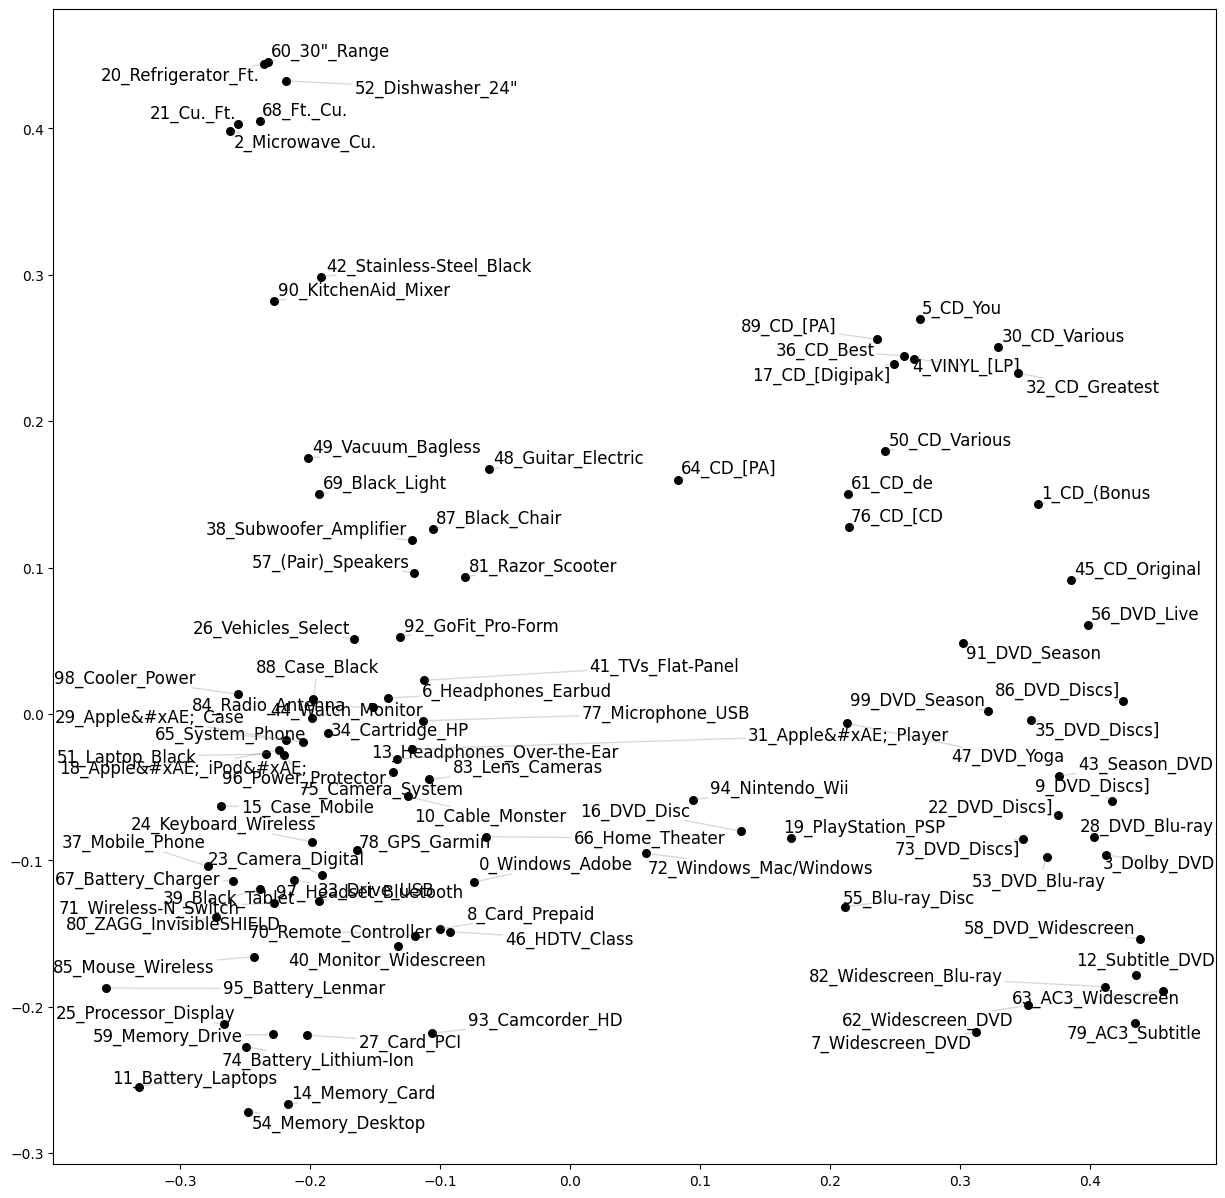

In [34]:
import collections, itertools, numpy as np, matplotlib.pyplot as plt
from adjustText import adjust_text
from sklearn.decomposition import PCA

stopwords = ["in", "for", "with", "of", "the", "to", "and"]

def top_words(clusters, top_n):
    # Loop through the clusters and split each string on space
    tokenized = [cluster.split() for cluster in clusters]
    # Flatten the list of lists
    flattened = list(itertools.chain.from_iterable(tokenized))
    filtered = [word for word in flattened
                if len(word) > 1 and word.lower() not in stopwords]
    
    # Return the most common words
    return [word for word, _ 
            in collections.Counter(filtered).most_common(top_n)]

#Transform the data for 2-D visualization
plt.figure(figsize=(15,15))
pca = PCA(100, svd_solver="full")
centers = algo.cluster_centers_
plot_data = pca.fit_transform(centers)
#plot_data = centers
#plt.scatter(plot_data[:,0] , plot_data[:,1] , s = 30, color = 'k')

points = []
for i, cluster_name in enumerate(plot_data):
    plt.scatter(plot_data[i,0], plot_data[i,1], s=30, color="k") 
    label = f"{i}_{'_'.join(top_words(clusters[i], 2))}"
    points.append(plt.text(plot_data[i,0], plot_data[i,1], label, size=12))
adjust_text(points, arrowprops=dict(arrowstyle="-", color="gray", alpha=.3))

In [35]:
clusters[1]  #useful for spot checking clusters to ensure items inside are homogenous

['21 (Bonus Tracks) - CD',
 '99 Luftballons - CD',
 'Graffiti [Deluxe Edition] - CD',
 'Out of Our Heads [UK] [Remaster] - CD',
 'The Obsidian Conspiracy - CD',
 'All Things Must Pass [30th... [Remaster] - CD',
 'Get Carter [Remastered] - CD',
 'Hotter Than Hell [Limited] [Remaster] - CD',
 'Sunrise Sessions [Deluxe Edition] [CD & DVD] [PA] - CD',
 'Anno Domini High Definition [Special Edition] - CD',
 'Enter The Dubstep Vol.2 [PA] - CD',
 'Rude Mechanicals [Reissue] - CD',
 'Love and Rockets [Expanded] [Remaster] - Deluxe Edition Remastered EP - CD',
 'Let It Be (Limited Edition) (Remastered) (Enhanced) - CD',
 'Private Room (Enhanced) - CD',
 'Special Edition - Rare Tracks (Japan) - CD',
 'Losers Weepers (Bonus Tracks) - CD',
 'In Session (CD+DVD) (Deluxe Edition) (Bril) - CD',
 'Wish You Were Here (Reissue) (Remastered) - CD',
 'Rhapsody In Blue - CD',
 'Death Certificate: Usda Edition (Remastered) - CD',
 'Waiting for the Sun [Bonus Tracks] [Remaster] - CD',
 'Remix Deluxe (Japan) 

In [36]:
#sample top keywords in each cluster (same as figure above, but more data)
for cluster_key in range(0,99):
    print(f"{{ cluster: {cluster_key}, top_words: {top_words(clusters[cluster_key], 20)}}}")

{ cluster: 0, top_words: ['Windows', 'Adobe', 'Mac', 'Mac/Windows', 'Upgrade', 'Suite', '2011', 'Edition', 'Pro', '2012', 'Version', 'Home', 'Creative', '5.5', 'Premium', 'Student', 'Microsoft', '2010', 'Office', 'Professional']}
{ cluster: 1, top_words: ['CD', '(Bonus', '[Remaster]', 'Edition)', '[Bonus', '(Deluxe', 'Tracks]', 'Tracks)', '(Remastered)', 'Edition]', 'DVD]', '[CD', '[Deluxe', '[PA]', 'Various', '(CD+DVD)', 'Vol.', '(Japan)', 'Edition', 'Track)']}
{ cluster: 2, top_words: ['Microwave', 'Cu.', 'Ft.', 'Stainless-Steel', 'Oven', 'Over-the-Range', 'Built-In', 'Black', 'Wall', 'GE', 'Electric', 'White', 'Convection', 'Mid-Size', 'Single', 'Toaster', 'Whirlpool', '30"', '2.0', 'Frigidaire']}
{ cluster: 3, top_words: ['Dolby', 'DVD', 'Widescreen', 'AC3', 'Subtitle', 'Fullscreen', 'Dts', 'Blu-ray', 'Disc', 'Dubbed', 'Sub', 'Special', 'Dub', 'Dol)', '(Ws', 'Discs]', 'WWE:', 'Ac3', 'Vol.', 'Series']}
{ cluster: 4, top_words: ['VINYL', '[LP]', '[PA]', 'Vinyl', 'CD', '12-Inch', 'Sin

In [37]:
import pandas as pd

### Create Pandas dataframes for product_clusters
product_ids_labels = dict(zip(product_ids, labels))
pddf_product_ids_labels = pd.DataFrame.from_dict(product_ids_labels, orient="index", columns=["label"])
pddf_product_ids_labels["pid"] = pddf_product_ids_labels.index

## Listing 9.15 Comparing approaches for mapping queries to product clusters

In [38]:
import sentence_transformers, heapq

## get the top n clusters based on similairty with centers 
def get_top_labels_centers(query, centers, n=2):
    q_embedding = transformer.encode([query], convert_to_tensor=False)
    similarities = sentence_transformers.util.cos_sim(q_embedding, centers)
    sim = similarities.tolist()[0]
    return [sim.index(i) for i in heapq.nlargest(n, sim)]

### Get the cluster for the query based on prediction of the label
def get_query_cluster(query):
    q_embedding = transformer.encode([query], convert_to_tensor=False)
    return algo.predict(q_embedding)

In [39]:
import random
random.seed(1234)

def get_cluster_description(cluser_num):
    return "_".join(top_words(clusters[cluser_num], 5))

query = "microwave"
#option 1: Find nearest cluster (KMeans)
kmeans_predict = get_query_cluster(query)[0]
print("KMeans Predicted Cluster:")
print(f"    {kmeans_predict} ({get_cluster_description(kmeans_predict)})")

#option 2: Find most similar cluster (Cosine similarity)
closest_cosine_similarity = get_top_labels_centers(query, centers, 1)[0]
print(f"""\nCosine Predicted Cluster:\n    {closest_cosine_similarity}
      {get_cluster_description(closest_cosine_similarity)})""")

#option 3: N-nearest clusters (Cosine similarity)
knn_cosine_similarity = get_top_labels_centers(query, centers, 5)
print(f"\nKNN Cosine Predicted Clusters: {knn_cosine_similarity}")
for n in knn_cosine_similarity:
      print(f"    {n} ({get_cluster_description(n)})")

KMeans Predicted Cluster:
    2 (Microwave_Cu._Ft._Stainless-Steel_Oven)

Cosine Predicted Cluster:
    2
      Microwave_Cu._Ft._Stainless-Steel_Oven)

KNN Cosine Predicted Clusters: [2, 42, 90, 60, 20]
    2 (Microwave_Cu._Ft._Stainless-Steel_Oven)
    42 (Stainless-Steel_Black_Maker_Coffeemaker_Cuisinart)
    90 (KitchenAid_Mixer_Stand_Black_Blender)
    60 (30"_Range_Stainless-Steel_Self-Cleaning_Freestanding)
    20 (Refrigerator_Ft._Cu._Stainless-Steel_Water)


In [40]:
sdf_id_labels = spark.createDataFrame(pddf_product_ids_labels).createOrReplaceTempView('products_clusters')

/usr/local/spark/python/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/usr/local/spark/python/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


In [41]:
# Load signal data to create user-product vectors
signals_collection = engine.get_collection("signals")
create_view_from_collection(signals_collection, "signals", spark)

In [42]:
#Create User-product data set for personalization
spark.sql("""SELECT DISTINCT user, target AS product_id, name AS product_name
FROM signals s JOIN products_samples p ON s.target = p.upc
WHERE s.type = 'click'""").createOrReplaceTempView("user_product")

query = """SELECT user, product_id, product_name, label FROM user_product a
JOIN products_clusters b ON a.product_id = b.pid"""

user_product_cluster_collection = engine.create_collection("user_product_cluster")
user_product_cluster_collection.write(from_sql(query, spark))

Wiping "user_product_cluster" collection
Creating "user_product_cluster" collection
Status: Success


In [43]:
## get the top n clusters based on similarity with centers 
def top_clusters_for_embedding(embedding, n=2):
    similarities = sentence_transformers.util.cos_sim(embedding, centers)
    sim = similarities.tolist()[0]
    return [sim.index(i) for i in heapq.nlargest(n, sim)]

## Listing 9.16

In [44]:
# importiong the modules
import pandas as pd, numpy as np
np.set_printoptions(4)

#Take user's product interests and return dataframe containing embedding and guardrail cluster
def get_user_embeddings(products=[]):
    values = []
    for p in products:
        values.append([product_ids_emb[p], top_clusters_for_embedding(product_ids_emb[p], 1)[0]])
    column_names = ["embedding", "cluster"]
    return pd.DataFrame(data=np.array(values), index=products, columns=column_names)

def get_personalization_vector(query=None,
                               user_items=[],
                               query_weight=1,
                               user_items_weights=[]):
    #by default, weight is split 1:1 (50% each) between the query embedding and the user_items_weight.
    #you can manually add weights for each user_item to influence how much each element counts.

    query_embedding = transformer.encode(query, convert_to_tensor=False) if query else None
    
    if len(user_items) > 0 and len(user_items_weights) == 0:
        user_items_weights = np.full(shape=len(user_items), fill_value=1 / len(user_items))
            
    embeddings = []
    embedding_weights = []
    for weight in user_items_weights:
        embedding_weights.append(weight) 
    for embedding in user_items:
        embeddings.append(embedding)
    if query_embedding.any():
        embedding_weights.append(query_weight)
        embeddings.append(query_embedding)
    
    return np.average(embeddings, weights=np.array(embedding_weights),
                      axis=0).astype("double") if len(embeddings) else None

## Listing 9.17

In [45]:
product_interests = [ "7610465823828",  #hello kitty water bottle
                      "36725569478"]   #stainless steel electric range

user_embeddings = get_user_embeddings(product_interests)
print(f"\nProducts Interactions for Personalization:\n {user_embeddings}")

query = "microwave"
unfiltered_personalization_vector = get_personalization_vector(query=query,
                        user_items=user_embeddings['embedding'].to_numpy())

vector_string = (", ".join([str(round(n, 3)) for n in unfiltered_personalization_vector]))[:70] + " ...]"
print("\nPersonalization Vector (No Cluster Guardrails):\n[" + vector_string)

query_clusters = get_top_labels_centers(query, centers, n=5)
print("\nQuery Clusters ('microwave'):\n" + str(query_clusters))

clustered = user_embeddings.cluster.isin(query_clusters)
products_in_cluster = user_embeddings[clustered] #filter down to only items in the query clusters
print("\nProducts Filtered to Query Clusters:\n" + str(products_in_cluster))

filtered_personalization_vector = get_personalization_vector(query=query,
                             user_items=products_in_cluster['embedding'].to_numpy())
vector_string = (", ".join([str(round(n, 3)) for n in filtered_personalization_vector]))[0:70] + " ...]"
print("\nFiltered Personalization Vector (With Cluster Guardrails):\n[" + vector_string)


Products Interactions for Personalization:
                                                        embedding cluster
7610465823828  [0.06417941, 0.04178553, -0.0017139615, -0.020...      49
36725569478    [0.0055417763, -0.024302201, -0.024139373, -0....      60

Personalization Vector (No Cluster Guardrails):
[0.016, -0.006, -0.02, -0.032, -0.016, 0.008, -0.0, 0.017, 0.011, 0.007 ...]

Query Clusters ('microwave'):
[2, 42, 90, 60, 20]

Products Filtered to Query Clusters:
                                                     embedding cluster
36725569478  [0.0055417763, -0.024302201, -0.024139373, -0....      60

Filtered Personalization Vector (With Cluster Guardrails):
[0.002, -0.023, -0.026, -0.037, -0.025, 0.002, -0.009, 0.007, 0.033, -0 ...]


/tmp/ipykernel_1970/2426286632.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return pd.DataFrame(data=np.array(values), index=products, columns=column_names)


## Listing 9.18

In [ ]:
# 4- Get all items for the search query using solr index
## Get the top items from the query cluster for the user
### User search query using solr 
#query="Western Digital - Scorpio Blue 250GB Internal Serial ATA Hard Drive for Laptops Serial ATA interface; quiet performance; 1.5GB/sec data transfer rate"

query = "microwave"
request = product_search_request(query)
request["limit"] = 100

response = products_collection.search(**request)
docs = response["docs"]
print("Search Results w/ No Personalization:")
display_product_search(query, docs[0:4])

In [ ]:
from operator import itemgetter

def rerank_with_personalization(docs, personalization_vector):
    result_embeddings = np.array([product_ids_emb[docs[x]['upc']]
                                  for x in range(len(docs))]).astype(float)
    similarities = sentence_transformers.util.cos_sim(
        personalization_vector, result_embeddings).tolist()[0]
    reranked = [similarities.index(i)
                for i in heapq.nlargest(len(similarities), similarities)]
    reranked, _ = zip(*sorted(enumerate(similarities),
                              key=itemgetter(1), reverse=True))
    return [docs[i] for i in reranked]
   
print("Personalized search results (no category guardrails):")
reranked_seach_results_no_guardrails = \
    rerank_with_personalization(docs, unfiltered_personalization_vector) 
display_product_search(query, reranked_seach_results_no_guardrails[0:4])

print("Personalized search results (with category guardrails):")
reranked_seach_results_with_guardrails = \
    rerank_with_personalization(docs, filtered_personalization_vector) 
display_product_search(query, reranked_seach_results_with_guardrails[0:4])


Personalized search results (no category guardrails):


Personalized search results (with category guardrails):


Up next: Chapter 10 - [Learning to Rank for Generalizable Search Relevance](../ch10/1.setup-the-movie-db.ipynb)